In [94]:
"""This cell is used to import all the necessary package"""

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import nn
import itertools
import matplotlib.pyplot as plt

In [95]:
""" 
    This cell is used to download the MNIST dataset.
    Split the train set it into initial(50%) and online(50%) data.
    Create dataloader for initial and online data.
"""

## Custom Dataset to get subset of a dataset
class SplitDataset(Dataset):
    def __init__(self, start, end, transform):
        self.train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
        self.start = start
        self.end = end
    
    def __len__(self):
        return self.end - self.start

    def __getitem__(self, idx):
        return self.train_dataset[idx + self.start]


## Traning Data
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,),)])
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)

## Initial and Online Data splitting
split = len(train_dataset) // 2
last_idx = len(train_dataset)
initial_data = SplitDataset(0, split, transform)
online_data = SplitDataset(split, last_idx, transform)

## Intial and online dataloader
initial_dataloader = DataLoader(initial_data, batch_size=32, shuffle=True)
online_dataloader = DataLoader(initial_data, batch_size=32, shuffle=True)

## Test Data
testset = torchvision.datasets.MNIST('/tmp', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

print("Initial Data Size: ", len(initial_data))
print("Online Data Size: ", len(online_data))
print("Test Data Size: ", len(testset))

Initial Data Size:  30000
Online Data Size:  30000
Test Data Size:  10000


In [96]:
"""In this cell we code the model architecture (MLP)"""

## Creating the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 26.2%, Avg loss: 2.260168 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 55.6%, Avg loss: 2.198419 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 64.2%, Avg loss: 2.092474 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 68.8%, Avg loss: 1.905147 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 71.8%, Avg loss: 1.620288 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 75.8%, Avg loss: 1.306050 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 79.3%, Avg loss: 1.050922 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.871637 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.748438 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.661163 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 85.4%, Avg los

Text(0, 0.5, 'Loss')

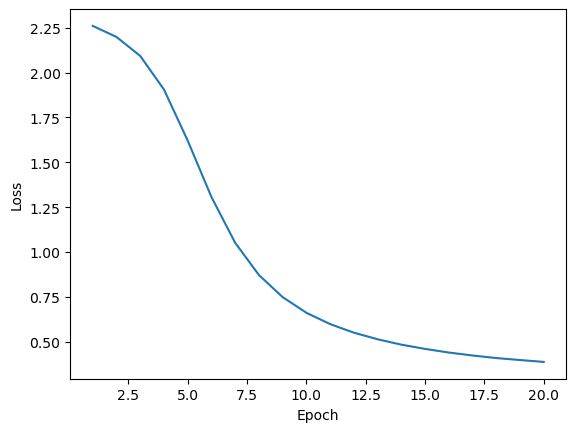

In [97]:
"""
    This cell contains code for train loop and test loop.
    The model is trained on the initial data
"""


## Tranning the with 50% of the traning data
def train(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

test_losses = []
for epoch in range(20):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(initial_dataloader, model, loss_fn, optimizer, device)
    test_loss, accuracy = test(testloader, model, loss_fn)
    test_losses.append(test_loss)


plt.clf()
plt.plot(range(1, len(test_losses) + 1), test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [98]:
def train_online(OnX, Ony, initial_dataloader, model, loss_fn, optimizer, device):
    # storing intial weights
    weights_initial = {name: parameter.clone() for name, parameter in model.named_parameters()}
    
    # traning with 5 batches of initial data
    i = 0
    for OfX, Ofy in initial_dataloader:
        if(i == 5):
            break
        OfX, Ofy = OfX.to(device), Ofy.to(device)
        conX, cony = torch.cat((OnX, OfX)), torch.cat((Ony, Ofy))
        output = model(conX)
        optimizer.zero_grad()
        loss = loss_fn(output, cony)
        loss.backward()
        optimizer.step()
        i += 1
        
    # modifying the weights with with weigth avarage to avoid catastrophic forgetting
    alpha = 0.7
    weights_new = {name: parameter.clone() for name, parameter in model.named_parameters()}
    for key in model.state_dict():
        model.state_dict()[key].data.copy_(alpha * weights_initial[key] + (1 - alpha) * weights_new[key])
        

## Return accuaracy and loss for the old dataset and new batches
def test_online(dataloader, new_batches, model, loss_fn, device, batch_size=32):
    size = 0
    num_batches = len(dataloader) + len(new_batches)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in itertools.chain(dataloader, new_batches):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            size += X.shape[0]
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"OldDataset and new batches Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct



In [99]:
"""Simulation of the online learning"""


New_batches = []
test_losses = []
train_losses = []
j = 0
for X, y in online_dataloader:
    if(j == 20):
        break
    
    print("\nSimulating the online learning with new batches: ", j + 1)
    X, y = X.to(device), y.to(device)
    train_online(X, y, initial_dataloader, model, loss_fn, optimizer, device)

    # reporting the accuracy of the model on the test data
    test_loss, _ = test(testloader, model, loss_fn)
    test_losses.append(test_loss)
    
    # reporting the accuracy of the model on the train_data and new batches
    New_batches.append((X, y))
    train_loss, _ = test_online(initial_dataloader, New_batches, model, loss_fn, device)
    train_losses.append(train_loss)
    
    j += 1


Simulating the online learning with new batches:  1
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.387350 

OldDataset and new batches Error: 
 Accuracy: 89.1%, Avg loss: 0.400914 


Simulating the online learning with new batches:  2
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.387201 

OldDataset and new batches Error: 
 Accuracy: 89.1%, Avg loss: 0.400682 


Simulating the online learning with new batches:  3
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.387210 

OldDataset and new batches Error: 
 Accuracy: 89.1%, Avg loss: 0.400592 


Simulating the online learning with new batches:  4
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.387163 

OldDataset and new batches Error: 
 Accuracy: 89.1%, Avg loss: 0.400512 


Simulating the online learning with new batches:  5
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.387132 

OldDataset and new batches Error: 
 Accuracy: 89.1%, Avg loss: 0.400783 


Simulating the online learning with new batches:  6
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.387152 



Text(0, 0.5, 'Loss')

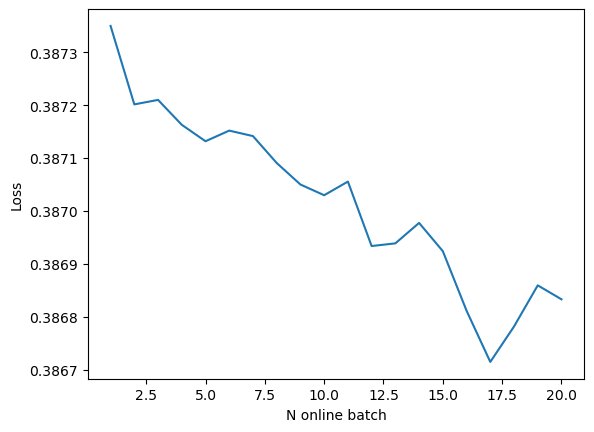

In [100]:
"""Loss plots for test loss for the online learning"""

plt.clf()
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('N online batch')
plt.ylabel('Loss')

Text(0, 0.5, 'OldDataset and new Batches Loss')

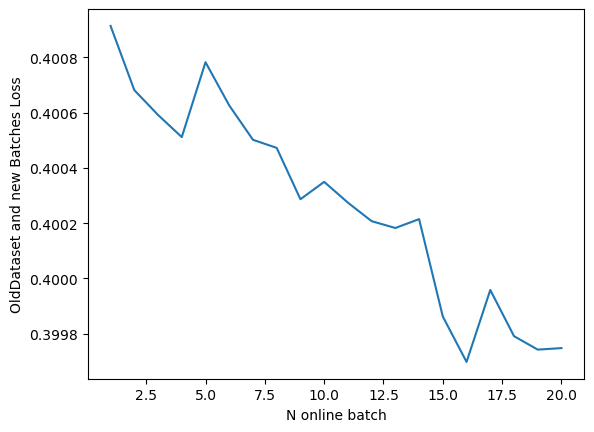

In [101]:
"""Loss plots for oldDataset and new batches loss for the online learning"""


plt.clf()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.xlabel('N online batch')
plt.ylabel('OldDataset and new Batches Loss')